## Sampling

After we explore the dataset, we proposed a Bayesian model. We used MCMC to sample the posterior distribution of the parameters. We also used optimization to get MAP.

In [23]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import ndimage
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import time
import pymc as pm
import seaborn as sns
sns.set_context('paper')
sns.set_style('white', )
from scipy.stats import multivariate_normal

** Read the Dataset **

In [10]:
new_data = pd.read_pickle('Data_Subset_5000_Year2013')
X = list(new_data[0])
Y = list(new_data[1])

In [18]:
param_labels = ['Longitude: West Mean','Latitude: North Mean','Longitude: East Mean','Latitude: South Mean','Longitude: West Var',\
'Northwest Guassian Cov','Latitude: North Var','Longitude: East Var','Southeast Guassian Cov','Latitude: South Var','Mixture Weight (Northwest Gaussian)']

**Define the posterior distribution we sample from**

In [ ]:
param_labels = ['Longitude: West Mean','Latitude: North Mean','Longitude: East Mean','Latitude: South Mean','Longitude: West Var',\
'Northwest Guassian Cov','Latitude: North Var','Longitude: East Var','Southeast Guassian Cov','Latitude: South Var','Mixture Weight (Northwest Gaussian)']
'''
Input: 
X, Y are both lists
mu1, mu2 are both a list of size 2 
sig1, sig2 are both 2*2 covariane matrices
w is the mixture weight

'''

def posterior_log(mu11, mu12, mu21, mu22, sig11, sig12, sig13, sig21, sig22, sig23, w):
#     start = time.time()

    sig1 = [[sig11, sig12], [sig12, sig13]]
    sig2 = [[sig21, sig22], [sig22, sig23]]
    
    if w < 0 or w > 1:
        print 'if W'
        print w
        return -np.inf
    
    if sig11<0 or sig21<0 or sig13<0 or sig23<0:
        print 'if1'
        print sig1
        print sig2
        
        return -np.inf
    
    det_sig1 = np.linalg.det(sig1)
    det_sig2 = np.linalg.det(sig2)
    
    if det_sig1<=0 or det_sig2<=0 : 
        print 'if2'
        return -np.inf
    
    rv1 = multivariate_normal([mu11, mu12], sig1)
    rv2 = multivariate_normal([mu21, mu22], sig2)

    Likeli = np.sum(np.log(w*rv1.pdf(np.array([X, Y]).T) + (1-w)*rv2.pdf(np.array([X, Y]).T)))
    return - np.log(det_sig1) - np.log(det_sig2) + Likeli

**Sample Posterior Distribution**

In [ ]:
## Metropolis Hastings here
def metropolis_hastings_sampler_CW(pdf,x0,sigma,log=False,sample_size=10,burnin=0, thin=0):
    
    start = time.time()
    num_params = len(x0)
    acc = np.zeros(num_params)
    result = np.zeros((sample_size, num_params))

    x_star = np.copy(x0)
    
    for i in xrange(sample_size):
        for j in xrange(num_params):
            x_star[j] = np.random.normal(x0[j], sigma[j])


            r = np.random.random()
            
            if log:
                accept_prob = pdf(*x_star) - pdf(*x0)
                accept = np.log(r) < accept_prob
                
            else:
                accept_prob = min(1,pdf(*x_star)/pdf(*x0))
                accept = r < accept_prob

            if accept:
                acc[j] += 1
                x0[j] = np.copy(x_star[j])
            else:
                x_star[j] = np.copy(x0[j])

        result[i,:] = x0
        
        if i%1000==0:
            print i
            
    end = time.time()
    
    if burnin !=0:
        result = result[burnin::]
    
    if thin !=0:
        result = result[::thin]
        
    
    print 'Metropolis-Hastings Elapsed time: ' , end-start    
    print 'Acceptance rate (%): ', 100*acc/sample_size
    
    return result

In [ ]:
burnin=200
thin=15
final_sample_size = 2000
sample_size = final_sample_size*thin+burnin


trace = metropolis_hastings_sampler_CW(posterior_log,x0,sigma,log=True,sample_size=sample_size,burnin=burnin, thin=thin)

# np.save('MHTrace_050215.npy',trace)

In [2]:
trace = np.load('MHTrace_050215.npy')
trace2 = np.load('MHTrace_Bad_050315.npy')

** Diagnosis Plots for MCMC **

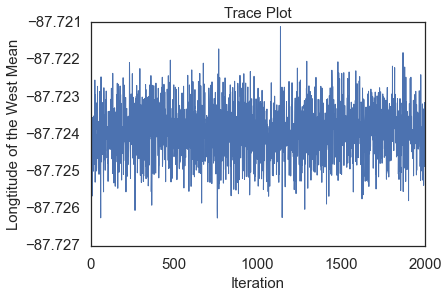

In [3]:
#Trace Plot
plt.figure()
plt.plot(trace[:, 0], linewidth = 1)
plt.title('Trace Plot')
plt.xlabel('Iteration')
plt.ylabel('Longtitude of the West Mean')
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.grid(b=False)

fig = plt.gcf()
fig.set_size_inches(6,4)
#plt.savefig('trace.png',dpi=300,bbox_inches='tight')

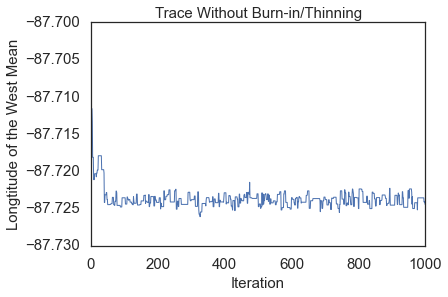

In [4]:
#Trace Plot
plt.figure()
plt.plot(trace2[:1000, 0], linewidth = 1)
plt.title('Trace Without Burn-in/Thinning')
plt.xlabel('Iteration')
plt.ylabel('Longtitude of the West Mean')
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
ax.get_yaxis().get_major_formatter().set_useOffset(False)    
plt.grid(b=False)

fig = plt.gcf()
fig.set_size_inches(6,4)
#plt.savefig('trace_bad.png',dpi=300,bbox_inches='tight')

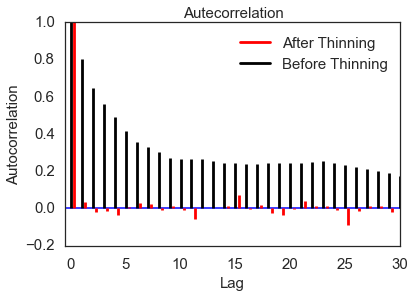

In [5]:
plt.figure()
lags1, c1, _, _ = plt.acorr(trace[:, 0] - np.mean(trace[:, 0]), maxlags=30,  normed=True, usevlines=True);
lags2, c2, _, _ = plt.acorr(trace2[:, 0] - np.mean(trace[:, 0]), maxlags=30,  normed=True, usevlines=True);

plt.clf()
plt.hlines(0,-0.5,30,color='b', linewidth = 1.5)
plt.vlines(x=(lags1+0.3), ymin=0, ymax=c1, label='After Thinning', color='r')
plt.vlines(x=lags2, ymin=0, ymax=c2, label='Before Thinning')
plt.xlim( (-0.5, 30))
plt.ylim([-0.2,1])
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autecorrelation')
    
plt.grid(b=False)
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
legend = plt.legend(prop={'size':15}, loc=1)

fig = plt.gcf()
fig.set_size_inches(6,4)
#plt.savefig('autocorr.png',dpi=300,bbox_inches='tight')

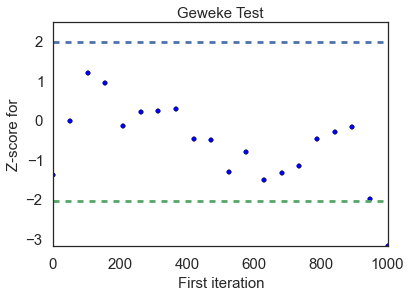

In [7]:
geweke_MH = pm.geweke(trace[:,0], first=0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_MH, '')
plt.title('Geweke Test')
plt.grid(b=False)
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
fig = plt.gcf()
fig.set_size_inches(6,4)
#plt.savefig('geweke.png',dpi=300,bbox_inches='tight')

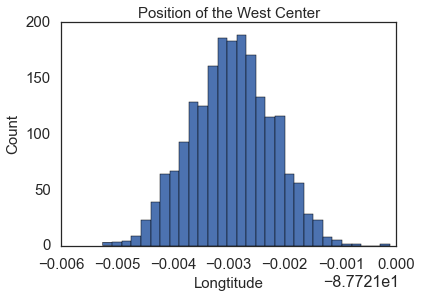

In [8]:
plt.hist(trace[:,0], bins=30)
plt.title('Position of the West Center')
plt.xlabel('Longtitude')
plt.ylabel('Count')
plt.grid(b=False)
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
fig = plt.gcf()
fig.set_size_inches(6,4)
#plt.savefig('tracehist.png',dpi=300,bbox_inches='tight')



**Compare Estimated Distribution with the Dataset**

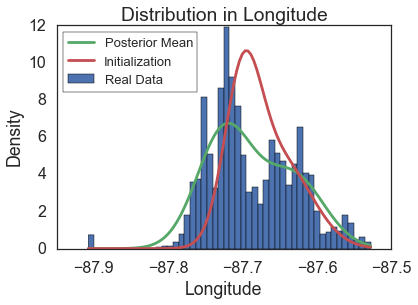

In [11]:
true = X
param = 0

sig1_init = [0.0006, 0.000059, 0.00147]
sig2_init = [0.0018, -0.00046, 0.0016]
x0 = [-87.7,41.85,-87.65,41.75]+sig1_init + sig2_init+[0.5] 

mean1 = trace.mean(axis=0)[param]
mean2 = trace.mean(axis=0)[param+2]
var1 = trace.mean(axis=0)[param*2+4]
var2 = trace.mean(axis=0)[param*2+7]
weight = trace.mean(axis=0)[10]

plt.hist(true, bins=50, normed=True, label='Real Data')
xs = np.linspace(min(true), max(true), 100)
plt.plot(xs, norm.pdf(xs, mean1, np.sqrt(var1))*weight + 
         norm.pdf(xs, mean2, np.sqrt(var2))*(1-weight),
        label='Posterior Mean')
plt.plot(xs, norm.pdf(xs, x0[param], np.sqrt(x0[param*2+4]))*x0[10] + 
         norm.pdf(xs, x0[param+2], np.sqrt(x0[param*2+7]))*(1-x0[10]),
        label='Initialization')
plt.ylabel('Density')
if param == 1:
    plt.xlabel('Latitude')
    plt.title('Distribution in Latitude')
else:
    plt.xlabel('Longitude')
    plt.title('Distribution in Longitude')
plt.legend()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
    
    
legend = plt.legend(frameon=True,prop={'size':13}, loc=2)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

fig = plt.gcf()
fig.set_size_inches(6,4)
#plt.savefig('MCMC' + str(param)+ '.png',dpi=300,bbox_inches='tight')

**Trane Plots for Each Parameter**

Longitude: West Mean


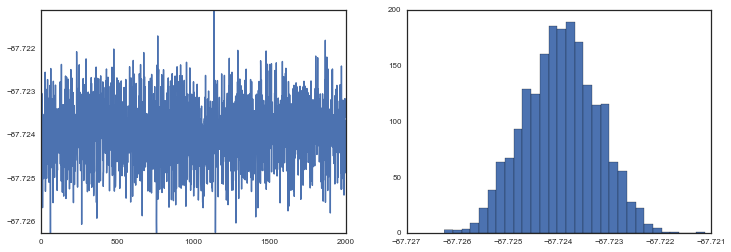

Latitude: North Mean


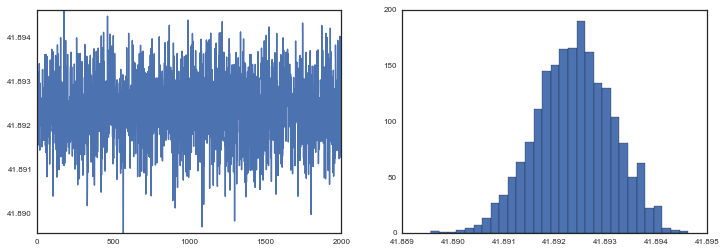

Longitude: East Mean


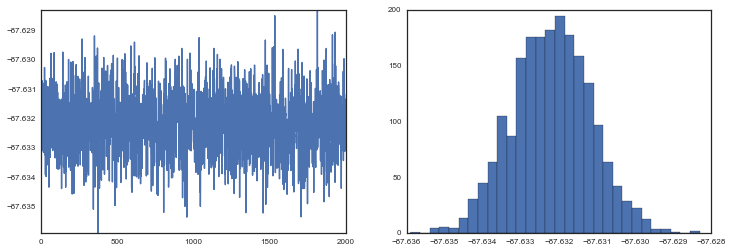

Latitude: South Mean


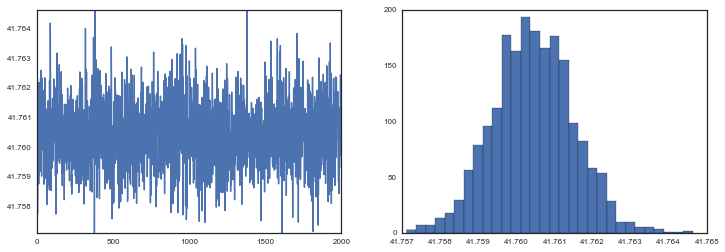

Longitude: West Var


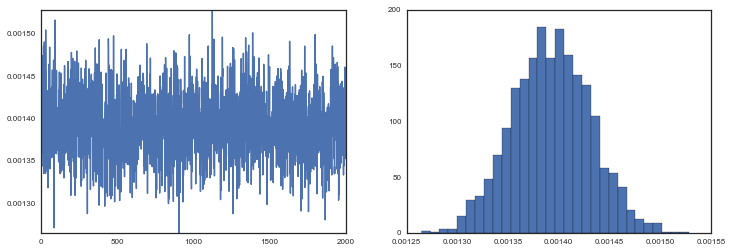

Northwest Guassian Cov


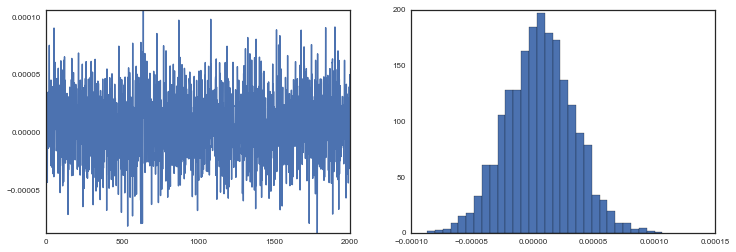

Latitude: North Var


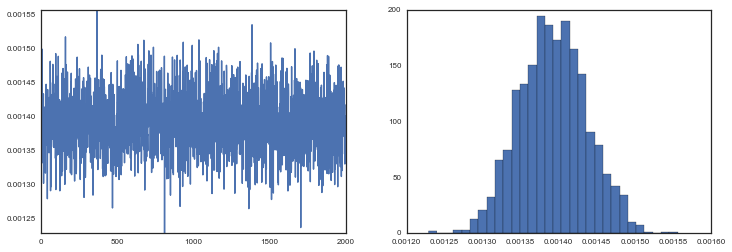

Longitude: East Var


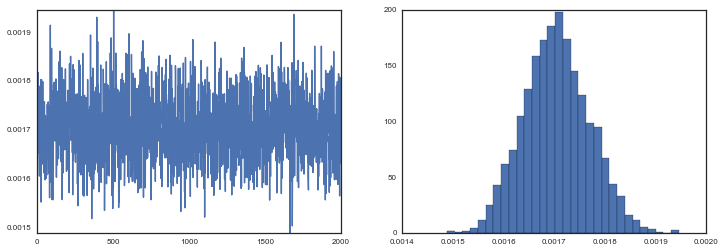

Southeast Guassian Cov


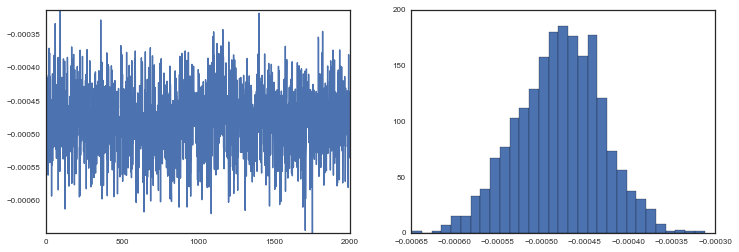

Latitude: South Var


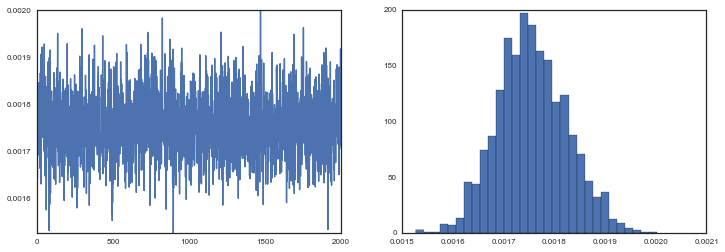

Mixture Weight (Northwest Gaussian)


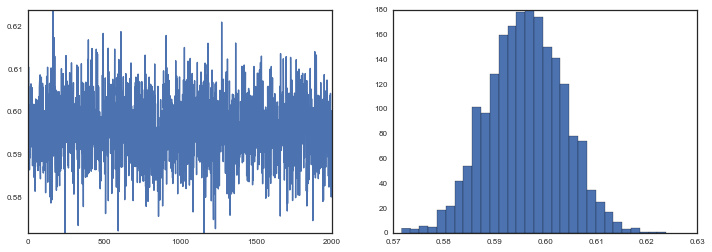

In [24]:
burnin=200
thin=15
final_sample_size = 2000
sample_size = final_sample_size*thin+burnin
samps = trace
for i in xrange(11):
    print param_labels[i]
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(samps[:,i])
    plt.axis([0,final_sample_size,min(samps[:,i]),max(samps[:,i])])
    ax = plt.gca()
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    
    plt.subplot(1,2,2)
    plt.hist(trace[:,i], bins=30)
    ax = plt.gca()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    plt.show()

** Geweke Test for All Parameters **

Longitude: West Mean


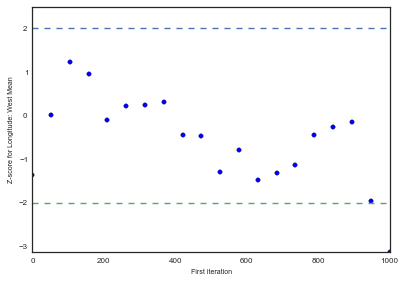

Latitude: North Mean


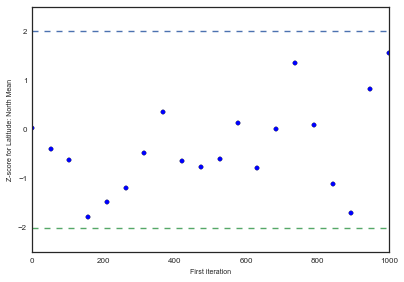

Longitude: East Mean


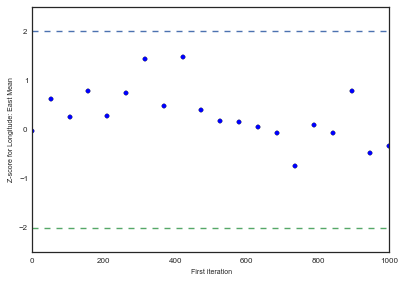

Latitude: South Mean


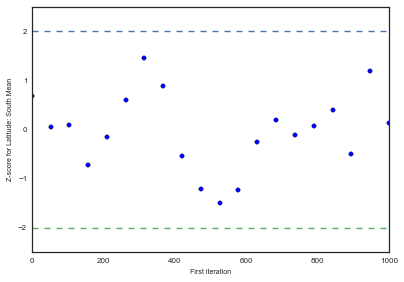

Longitude: West Var


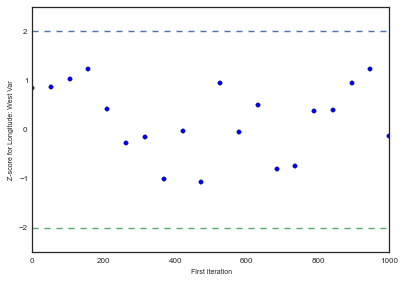

Northwest Guassian Cov


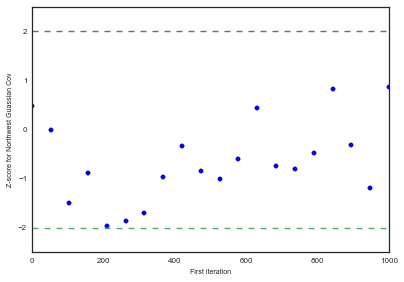

Latitude: North Var


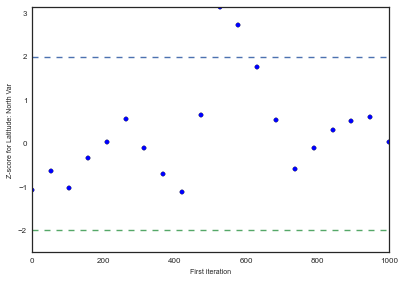

Longitude: East Var


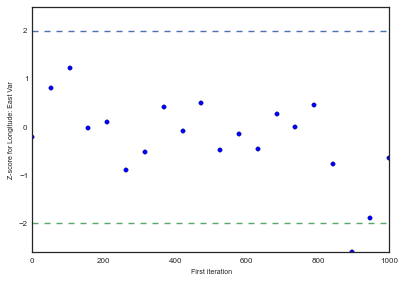

Southeast Guassian Cov


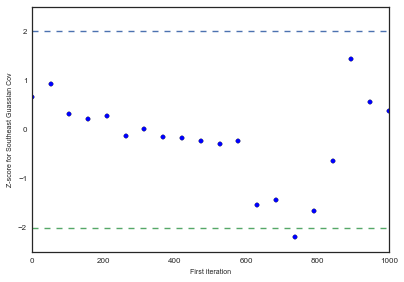

Latitude: South Var


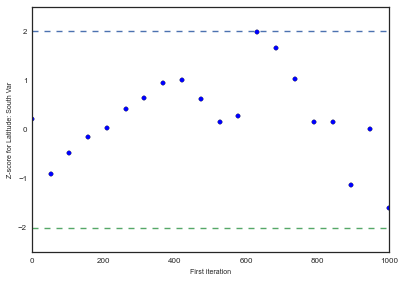

Mixture Weight (Northwest Gaussian)


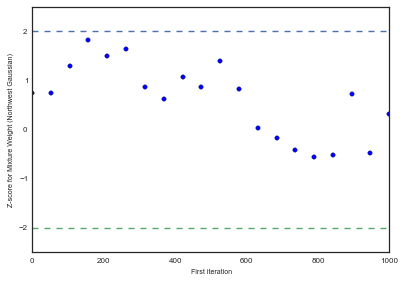

In [25]:
for i in xrange(11):
    print param_labels[i]
    geweke_MH = pm.geweke(trace[:,i], first=0.1, last=0.5, intervals=20)
    pm.Matplot.geweke_plot(geweke_MH, param_labels[i])
    plt.show()

### Estimate Parameters by Maximizing Posterior Distribution

**Define the posterior distribution we want to optimize **

In [ ]:
new_data = pd.read_pickle('Data_Subset_5000_Year2013')
X = list(new_data[0])
Y = list(new_data[1])
len(Y)
count1 = [0]
count2 = [0]

'''
Input: 
X, Y are both lists
mu1, mu2 are both a list of size 2 
sig1, sig2 are both 2*2 matrix
w is the weight

Notes:
Likelihood is a mixture Gaussian with weights w and 1-w
Prior is flat: 1/det(sig1)*det(sig2)
Posterior is Prior*Likelihood
'''

def posterior_log(x0):
    mu11 = x0[0]
    mu12 = x0[1]
    mu21 = x0[2]
    mu22 = x0[3]
    sig11 = x0[4]
    sig12 = x0[5]
    sig13 = x0[6]
    sig21 = x0[7]
    sig22 = x0[8]
    sig23 = x0[9]
    w = x0[10]

    if w < 0 or w > 1:
        return -np.inf
    
    if sig11<0 or sig21<0 or sig13<0 or sig23<0:
        count1[0] += 1
        if count1[0]%100 == 0:
            print 'Count1 ', count1[0]
        return np.inf
    
    if sig11*sig13-sig12**2<=0 or sig21*sig23-sig22**2<=0 : 
        count2[0] += 1
        if count2[0]%100 == 0:
            print 'Count2 ', count2[0]
        return np.inf
    
    sig1 = [[sig11, sig12], [sig12, sig13]]
    sig2 = [[sig21, sig22], [sig22, sig23]]
    
    det_sig1 = np.linalg.det(sig1)
    det_sig2 = np.linalg.det(sig2)
    rv1 = multivariate_normal([mu11, mu12], sig1)
    rv2 = multivariate_normal([mu21, mu22], sig2)

    Likeli = np.sum(np.log(w*rv1.pdf(np.array([X, Y]).T) + (1-w)*rv2.pdf(np.array([X, Y]).T)))

    return + np.log(det_sig1) + np.log(det_sig2) - Likeli

**Optimize Posterior Distribution with Nelder-Mead**

In [ ]:
sig1_init = [0.0006, 0.000059, 0.00147]
sig2_init = [0.0018, -0.00046, 0.0016]

'''
[mu11, mu12, mu13, mu22], [sig11, sig12, sig13], [sig21, sig22, sig23], w
mu11 and mu13 are means in longtitude , mu12 and mu22 are 2 latitude means
Here we assume that the longtitude has 2 peaks and latitude has 2 peaks
'''

x0 = [-87.7,41.85,-87.65,41.75]+sig1_init + sig2_init+[0.1] 

start = time.time()
results = sp.optimize.minimize(posterior_log, np.array(x0), method = 'Nelder-Mead', options={'maxiter':10**5,'maxfev':10000})

end = time.time()
print 'Elapsed time(s): ',end-start

** The MAP by Optimization **

In [27]:
# Initial Points
sig1_init = [0.0006, 0.000059, 0.00147]
sig2_init = [0.0018, -0.00046, 0.0016]


x0 = [-87.7,41.85,-87.65,41.75]+sig1_init + sig2_init+[0.5] 

optimized_params = np.array([ -8.77244167e+01,   4.18949718e+01,  -8.76400932e+01,
         4.17692568e+01,   7.36514126e-04,   4.26864583e-05,
         9.81215347e-04,   2.40355769e-03,  -5.18153935e-04,
         1.91673231e-03,   5.30472377e-01])

In [28]:
zip(param_labels,optimized_params)

[('Longitude: West Mean', -87.724416700000006),
 ('Latitude: North Mean', 41.8949718),
 ('Longitude: East Mean', -87.640093199999995),
 ('Latitude: South Mean', 41.769256800000001),
 ('Longitude: West Var', 0.000736514126),
 ('Northwest Guassian Cov', 4.2686458299999999e-05),
 ('Latitude: North Var', 0.00098121534700000004),
 ('Longitude: East Var', 0.00240355769),
 ('Southeast Guassian Cov', -0.00051815393499999999),
 ('Latitude: South Var', 0.00191673231),
 ('Mixture Weight (Northwest Gaussian)', 0.53047237700000005)]

In [30]:

long_mcmc_west_mean = optimized_params[0]
lat_mcmc_north_mean = optimized_params[1]
long_mcmc_east_mean = optimized_params[2]
lat_mcmc_south_mean = optimized_params[3]

long_mcmc_west_SD = np.sqrt(optimized_params[4])
mcmc_northwest_GuassianCorr = optimized_params[5]
lat_mcmc_north_SD = np.sqrt(optimized_params[6])

long_mcmc_east_SD = np.sqrt(optimized_params[7])
mcmc_southeast_GuassianCorr = optimized_params[8]
lat_mcmc_south_SD = np.sqrt(optimized_params[9])

mcmc_northwest_MixtureWeight = optimized_params[10]

# Longitude
optimized_long = np.concatenate([norm(loc=long_mcmc_west_mean,scale=long_mcmc_west_SD).rvs(mcmc_northwest_MixtureWeight*5000),\
                               norm(loc=long_mcmc_east_mean, scale=long_mcmc_east_SD).rvs((1-mcmc_northwest_MixtureWeight)*5000)])

# Latitude
optimized_lat = np.concatenate([norm(loc=lat_mcmc_north_mean,scale=lat_mcmc_north_SD).rvs(mcmc_northwest_MixtureWeight*5000),\
                               norm(loc=lat_mcmc_south_mean, scale=lat_mcmc_south_SD).rvs((1-mcmc_northwest_MixtureWeight)*5000)])



**Compare Estimated Distribution with the Dataset**

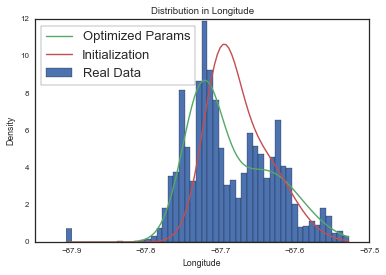

In [26]:
true = X
param = 0

sig1_init = [0.0006, 0.000059, 0.00147]
sig2_init = [0.0018, -0.00046, 0.0016]
x0 = [-87.7,41.85,-87.65,41.75]+sig1_init + sig2_init+[0.5] 
optimized_params = np.array([ -8.77244167e+01,   4.18949718e+01,  -8.76400932e+01,
         4.17692568e+01,   7.36514126e-04,   4.26864583e-05,
         9.81215347e-04,   2.40355769e-03,  -5.18153935e-04,
         1.91673231e-03,   5.30472377e-01])

mean1 = trace.mean(axis=0)[param]
mean2 = trace.mean(axis=0)[param+2]
var1 = trace.mean(axis=0)[param*2+4]
var2 = trace.mean(axis=0)[param*2+7]
weight = trace.mean(axis=0)[10]

plt.hist(true, bins=50, normed=True, label='Real Data')
xs = np.linspace(min(true), max(true), 100)
plt.plot(xs, norm.pdf(xs, optimized_params[param], np.sqrt(optimized_params[param*2+4]))*optimized_params[10] + 
         norm.pdf(xs, optimized_params[param+2], np.sqrt(optimized_params[param*2+7]))*(1-optimized_params[10]),
        label='Optimized Params')
plt.plot(xs, norm.pdf(xs, x0[param], np.sqrt(x0[param*2+4]))*x0[10] + 
         norm.pdf(xs, x0[param+2], np.sqrt(x0[param*2+7]))*(1-x0[10]),
        label='Initialization')
plt.ylabel('Density')
if param == 1:
    plt.xlabel('Latitude')
    plt.title('Distribution in Latitude')
else:
    plt.xlabel('Longitude')
    plt.title('Distribution in Longitude')
plt.legend()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
    
    
legend = plt.legend(frameon=True,prop={'size':13}, loc=2)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

fig = plt.gcf()
fig.set_size_inches(6,4)
#plt.savefig('optim' + str(param)+ '.png',dpi=300,bbox_inches='tight')